# LangChain 核心模块：Data Conneciton - Document Loaders

使用文档加载器从源中加载数据作为文档。一个文档是一段文字和相关的元数据。


例如，有用于加载简单 .txt 文件的文档加载器，用于加载 ArXiv 论文，或者任何网页的文本内容


### Document 类

这段代码定义了一个名为`Document`的类，允许用户与文档的内容进行交互，可以查看文档的段落、摘要，以及使用查找功能来查询文档中的特定字符串。

```python
# 基于BaseModel定义的文档类。
class Document(BaseModel):
    """接口，用于与文档进行交互。"""

    # 文档的主要内容。
    page_content: str
    # 用于查找的字符串。
    lookup_str: str = ""
    # 查找的索引，初次默认为0。
    lookup_index = 0
    # 用于存储任何与文档相关的元数据。
    metadata: dict = Field(default_factory=dict)

    @property
    def paragraphs(self) -> List[str]:
        """页面的段落列表。"""
        # 使用"\n\n"将内容分割为多个段落。
        return self.page_content.split("\n\n")

    @property
    def summary(self) -> str:
        """页面的摘要（即第一段）。"""
        # 返回第一个段落作为摘要。
        return self.paragraphs[0]

    # 这个方法模仿命令行中的查找功能。
    def lookup(self, string: str) -> str:
        """在页面中查找一个词，模仿cmd-F功能。"""
        # 如果输入的字符串与当前的查找字符串不同，则重置查找字符串和索引。
        if string.lower() != self.lookup_str:
            self.lookup_str = string.lower()
            self.lookup_index = 0
        else:
            # 如果输入的字符串与当前的查找字符串相同，则查找索引加1。
            self.lookup_index += 1
        # 找出所有包含查找字符串的段落。
        lookups = [p for p in self.paragraphs if self.lookup_str in p.lower()]
        # 根据查找结果返回相应的信息。
        if len(lookups) == 0:
            return "No Results"
        elif self.lookup_index >= len(lookups):
            return "No More Results"
        else:
            result_prefix = f"(Result {self.lookup_index + 1}/{len(lookups)})"
            return f"{result_prefix} {lookups[self.lookup_index]}"
```


### BaseLoader 类定义

`BaseLoader` 类定义了如何从不同的数据源加载文档，并提供了一个可选的方法来分割加载的文档。使用这个类作为基础，开发者可以为特定的数据源创建自定义的加载器，并确保所有这些加载器都提供了加载数据的方法。load_and_split方法还提供了一个额外的功能，可以根据需要将加载的文档分割为更小的块。

```python
# 基础加载器类。
class BaseLoader(ABC):
    """基础加载器类定义。"""

    # 抽象方法，所有子类必须实现此方法。
    @abstractmethod
    def load(self) -> List[Document]:
        """加载数据并将其转换为文档对象。"""

    # 该方法可以加载文档，并将其分割为更小的块。
    def load_and_split(
        self, text_splitter: Optional[TextSplitter] = None
    ) -> List[Document]:
        """加载文档并分割成块。"""
        # 如果没有提供特定的文本分割器，使用默认的字符文本分割器。
        if text_splitter is None:
            _text_splitter: TextSplitter = RecursiveCharacterTextSplitter()
        else:
            _text_splitter = text_splitter
        # 先加载文档。
        docs = self.load()
        # 然后使用_text_splitter来分割每一个文档。
        return _text_splitter.split_documents(docs)
```

## 使用 TextLoader 加载 Txt 文件

基于文件格式的内置 Loaders: https://python.langchain.com/docs/modules/data_connection/document_loaders/

In [1]:
from langchain.document_loaders import TextLoader

docs = TextLoader('state_of_the_union.txt',encoding='utf-8').load()

docs

[Document(metadata={'source': 'state_of_the_union.txt'}, page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determin

In [3]:
type(docs[0])

langchain_core.documents.base.Document

In [4]:
docs[0].page_content[:100]

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and th'

## 使用 ArxivLoader 加载 ArXiv 论文

代码实现：https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/document_loaders/arxiv.py

### ArxivLoader 类定义

`ArxivLoader` 类专门用于从Arxiv平台获取文档。用户提供一个搜索查询，然后加载器与Arxiv API交互，以检索与该查询相关的文档列表。这些文档然后以标准的Document格式返回。

```python
# 针对Arxiv平台的加载器类。
class ArxivLoader(BaseLoader):
    """从`Arxiv`加载基于搜索查询的文档。

    此加载器负责将Arxiv的原始PDF文档转换为纯文本格式，以便于处理。
    """

    # 初始化方法。
    def __init__(
        self,
        query: str,
        load_max_docs: Optional[int] = 100,
        load_all_available_meta: Optional[bool] = False,
    ):
        self.query = query
        """传递给Arxiv API进行搜索的特定查询或关键字。"""
        self.load_max_docs = load_max_docs
        """从搜索中检索文档的上限。"""
        self.load_all_available_meta = load_all_available_meta
        """决定是否加载与文档关联的所有元数据的标志。"""

    # 基于查询获取文档的加载方法。
    def load(self) -> List[Document]:
        arxiv_client = ArxivAPIWrapper(
            load_max_docs=self.load_max_docs,
            load_all_available_meta=self.load_all_available_meta,
        )
        docs = arxiv_client.search(self.query)
        return docs
```

ArxivLoader有以下参数：

- query：用于在`ArXiv`中查找文档的文本
- load_max_docs：默认值为100。使用它来限制下载的文档数量。下载所有100个文档需要时间，因此在实验中请使用较小的数字。
- load_all_available_meta：默认值为False。默认情况下只下载最重要的字段：发布日期（文档发布/最后更新日期）、标题、作者、摘要。如果设置为True，则还会下载其他字段。

以 **GPT-3 论文（Language Models are Few-Shot Learners）** 为例，展示如何使用 `ArxivLoader`

GPT-3 论文的 Arxiv 链接：https://arxiv.org/abs/2005.14165

In [5]:
# 安装必要依赖包
!pip install arxiv pymupdf

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 2.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=8e082b350893b3ef346d0be5c4fc6d9fe389bb06f1c77ac75962e357d12ddebd
  Stored in directory: /Users/superyaoyao/Library/Caches/pip/wheels/ff/5f/8c/37dae50519907e940875a81d62f9424b4172ccfbd8524111aa
Successfully built sgmllib3k
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts

In [6]:
from langchain.document_loaders import ArxivLoader

query = "2005.14165"

docs = ArxivLoader(query=query, load_max_docs=5).load()

In [7]:
len(docs)

1

In [8]:
docs[0].metadata  # meta-information of the Document

{'Published': '2020-07-22',
 'Title': 'Language Models are Few-Shot Learners',
 'Authors': 'Tom B. Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared Kaplan, Prafulla Dhariwal, Arvind Neelakantan, Pranav Shyam, Girish Sastry, Amanda Askell, Sandhini Agarwal, Ariel Herbert-Voss, Gretchen Krueger, Tom Henighan, Rewon Child, Aditya Ramesh, Daniel M. Ziegler, Jeffrey Wu, Clemens Winter, Christopher Hesse, Mark Chen, Eric Sigler, Mateusz Litwin, Scott Gray, Benjamin Chess, Jack Clark, Christopher Berner, Sam McCandlish, Alec Radford, Ilya Sutskever, Dario Amodei',
 'Summary': "Recent work has demonstrated substantial gains on many NLP tasks and\nbenchmarks by pre-training on a large corpus of text followed by fine-tuning on\na specific task. While typically task-agnostic in architecture, this method\nstill requires task-specific fine-tuning datasets of thousands or tens of\nthousands of examples. By contrast, humans can generally perform a new language\ntask from only a few examples o

In [2]:
pip uninstall youtube-transcript-api -y

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install youtube-transcript-api==0.4.4

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Using cached https://mirrors.aliyun.com/pypi/packages/d3/aa/38507c8d469a46fc0e9d40343c4f1007ee9d40d22443a4689b35ac69d024/youtube_transcript_api-0.4.4-py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install bilibili-api-python

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


## 使用 UnstructuredURLLoader 加载网页内容

使用非结构化分区函数(Unstructured)来检测MIME类型并将文件路由到适当的分区器(partitioner)。

支持两种模式运行加载程序："single"和"elements"。如果使用"single"模式，文档将作为单个langchain Document对象返回。如果使用"elements"模式，非结构化库将把文档拆分成标题和叙述文本等元素。您可以在mode后面传入其他非结构化kwargs以应用不同的非结构化设置。

以biibili为例：

该加载器利用 bilibili-api 从 哔哩哔哩 视频中检索文本转录。要有效使用此加载器，必须拥有 sessdata、bili_jct 和 buvid3 cookie 参数。这些参数可以通过登录 哔哩哔哩 获取，然后从浏览器的开发者工具中提取 sessdata、bili_jct 和 buvid3 的值。

如果您选择留空 cookie 参数，加载器仍然可以正常工作，但它只会检索元数据的视频信息，而无法获取转录内容。

有关获取这些凭据的详细说明，请参阅 此处 的指南。

BiliBiliLoader 提供了一个用户友好的界面，便于轻松访问哔哩哔哩上所需视频内容的转录，使其成为分析或利用这些媒体数据的宝贵工具。

## 各类缓存获取，须加载进bilibili的cookie：

https://www.bilibili.com/opus/552054768152938918

或者推荐直接自己在开发者（f12 或 fn+f12）模式下，在网页前端自己找。
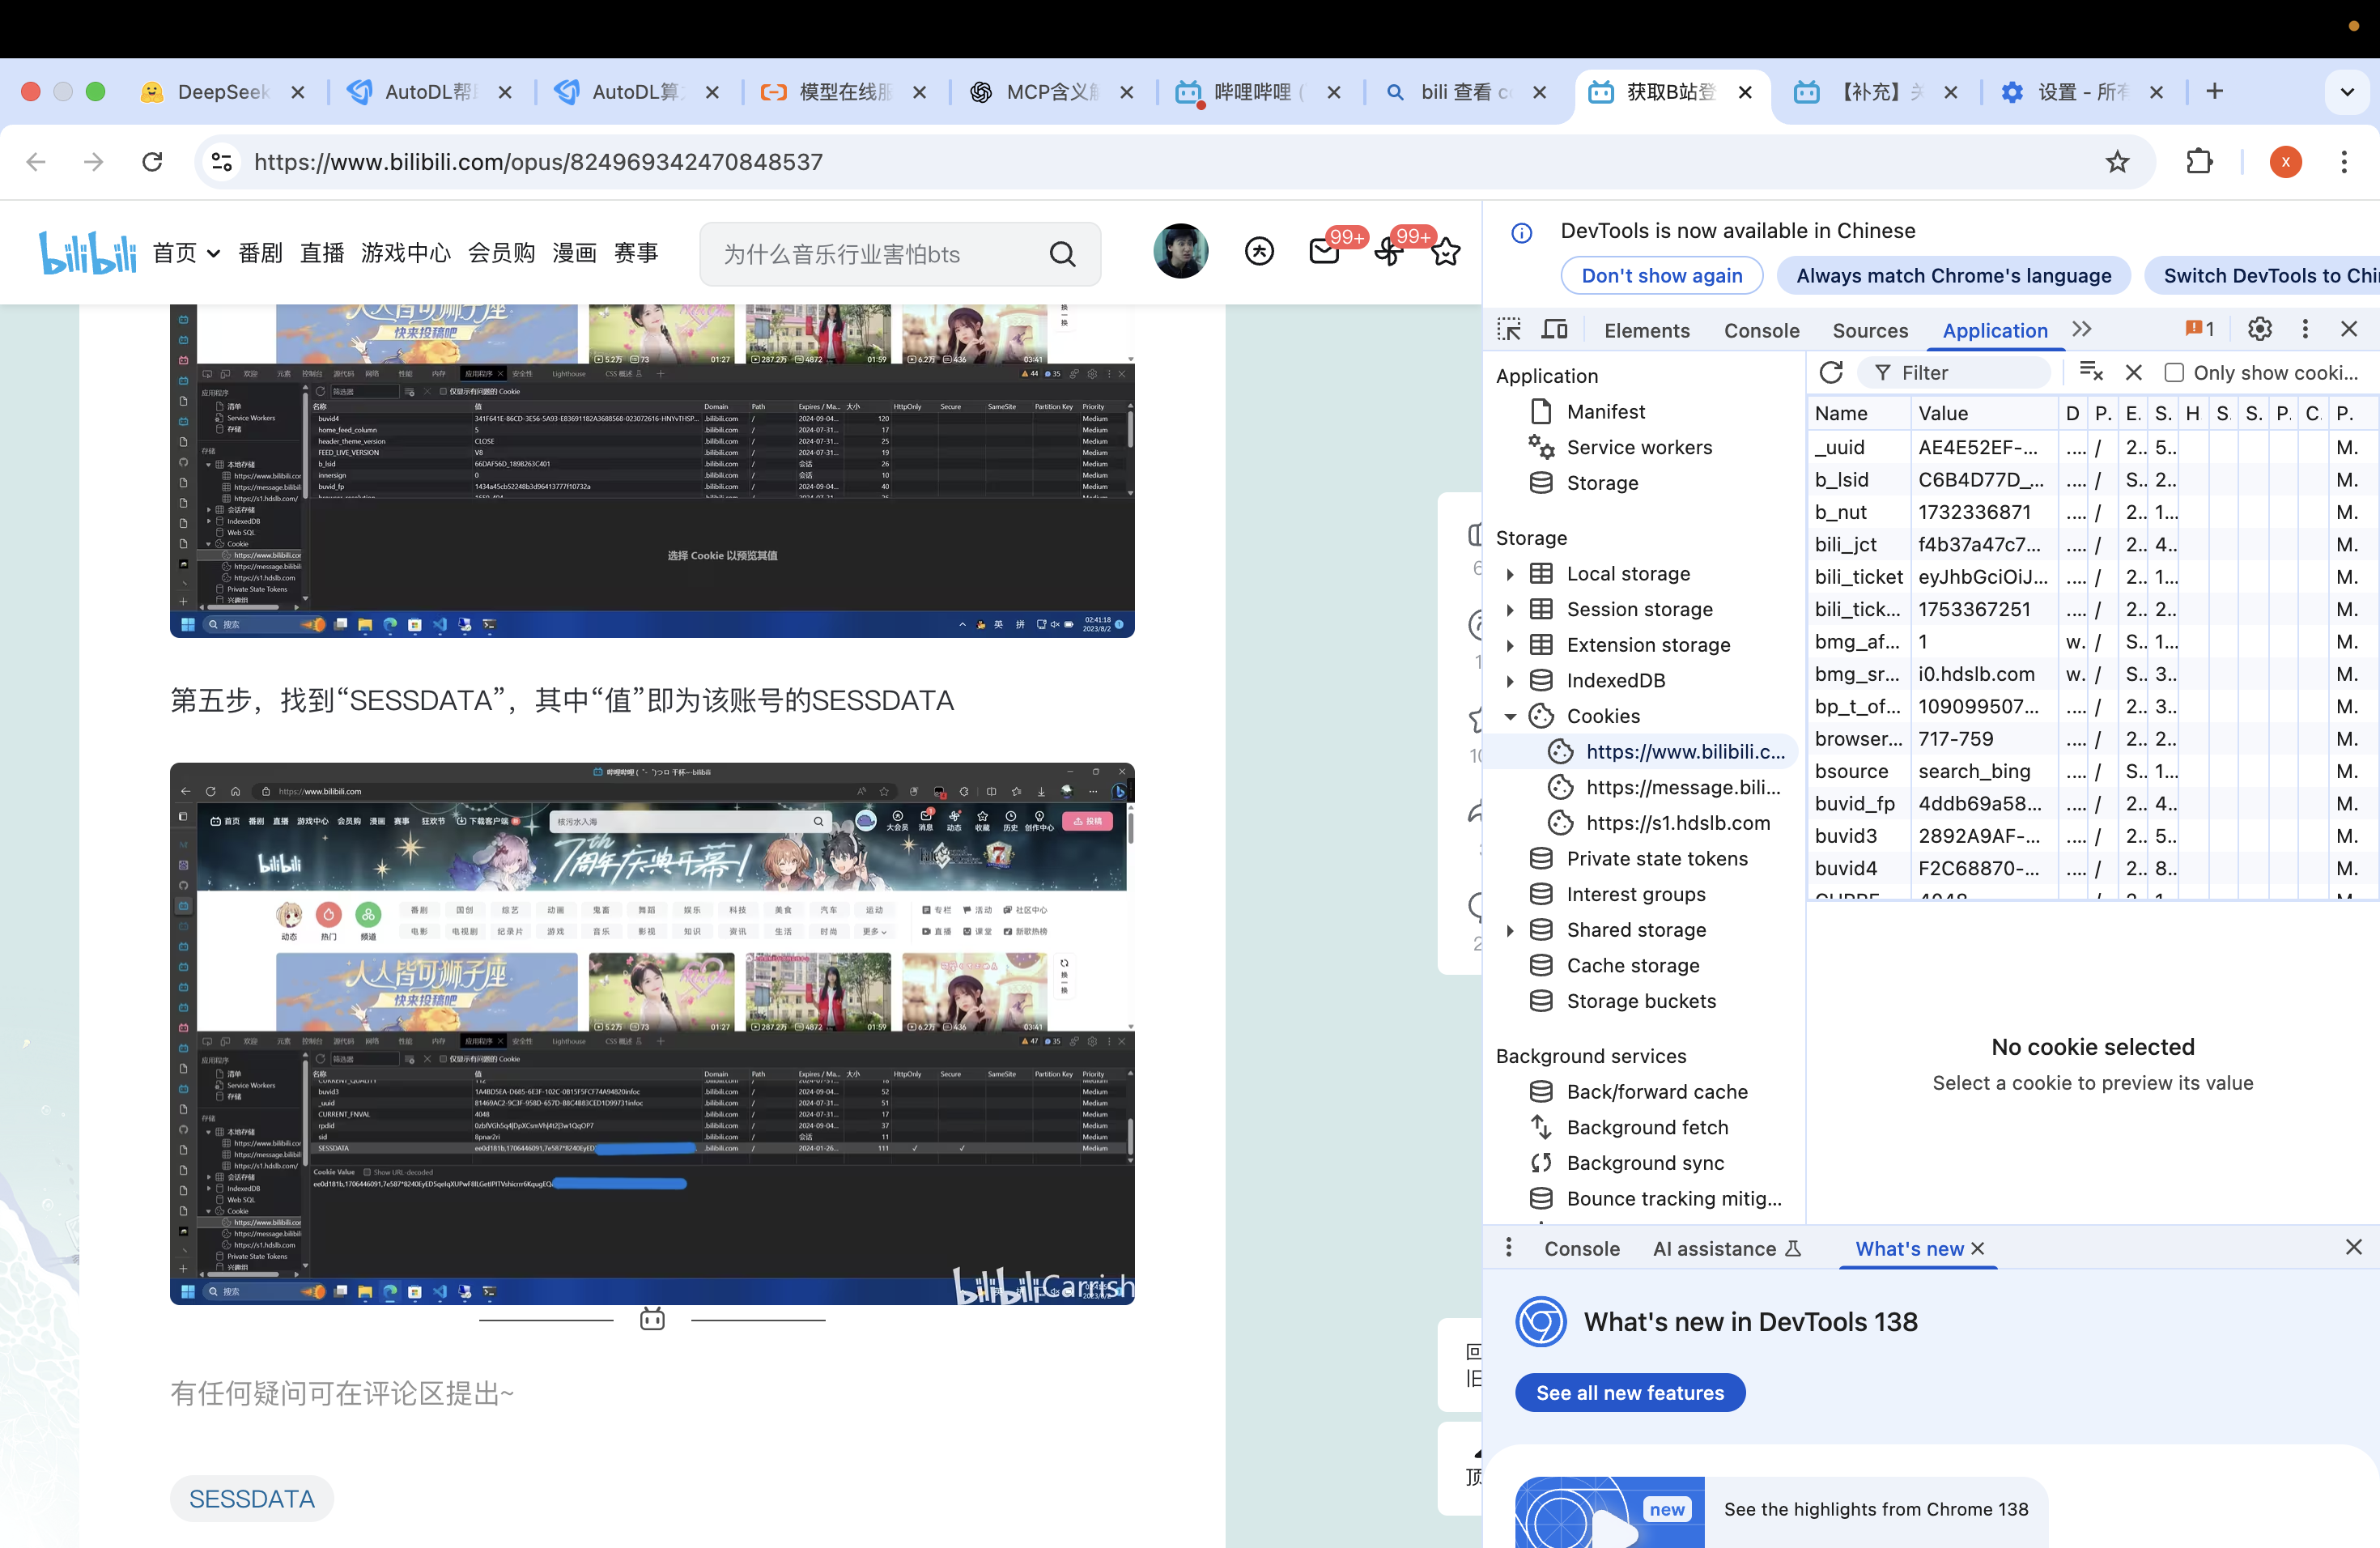

In [1]:
from langchain_community.document_loaders import BiliBiliLoader



In [2]:
SESSDATA = "4bcf3693%2C1768868351%2C64dc3%2A72CjAWR9eUeAwnMwQqIgsMADoZat-vLEBWJT5jyYTs9Z36Fw9j5IL_DHy60TjKr8qvGwsSVmlycUZnRmxQVTJXXzNPQ2ROOGVoR3BxalZPMHJZdW9kWGJOWDVlZTBGUVJPQU1QQTJpcnVnMWhqQXZ5M0xCY2ZFbXR4NVcyb3dMMlVpdHlwX0VVNU9nIIEC"
BUVID3 = "2892A9AF-C5EA-BC51-6D7B-CA7CEBF5C85671982infoc"
BILI_JCT = "f4b37a47c705f77c120cb1f609fe4b89"

In [3]:
loader = BiliBiliLoader(
    [
        "https://www.bilibili.com/video/BV1g84y1R7oE/",
    ],
    sessdata=SESSDATA,
    bili_jct=BILI_JCT,
    buvid3=BUVID3,
)

In [4]:
docs = loader.load()

In [6]:
docs

[Document(metadata={'bvid': 'BV1g84y1R7oE', 'aid': 620074163, 'videos': 1, 'tid': 208, 'tid_v2': 2085, 'tname': '校园学习', 'tname_v2': '非应试语言学习', 'copyright': 1, 'pic': 'http://i2.hdslb.com/bfs/archive/49c2a3612efe1caad023973ca56d979aabc30922.jpg', 'title': "Let's Learn English on a Hike! 🍂🚶🏼🎒 【英文字幕】", 'pubdate': 1698108310, 'ctime': 1698108310, 'desc': "Have you ever learned English in nature? In this English lesson I take you to a hiking trail near me and teach you all of the words and phrases you'll need to know to have a conversation about hiking.\n\nIn this free English class you'll learn words and phrases like: trail, path, treacherous, view, sign, observation deck, gear, hiking boots, dangerous animals, racoon, skunk, and more.\n\nYou'll even see a squirrel and hear me say the word, which is supposed to be one of the hardest English words to pronounce! Maybe hit pause at that point and try to shadow me saying the word (repeat it after me).\n\nI hope you enjoy this English lesson an